### What is a classification problem?
A classification problem involves predicting whether something is one thing or another.

For example, you might want to:

| Problem type | What is it? | Example |
|--------------|-------------|-----------|
| Binary classification | Target can be one of two options, e.g. yes or | Predict whether or not someone has heart disease based on their health parameters. |
| Multi-class classification | Target can be one of more than two options | Decide whether a photo of is of food, a person or a dog. |
| Multi-label classification | Target can be assigned more than one option | Predict what categories should be assigned to a Wikipedia article (e.g. mathematics, science & philosohpy). |

# Building a multi-class PyTorch model

### 1 Creating mutli-class classification data
To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's `make_blobs()` method.

This method will create however many classes (using the `centers` parameter) we want.

Specifically, let's do the following:

1.   Create some multi-class data with `make_blobs()`.
2.   Turn the data into tensors (the default of `make_blobs()` is to use NumPy arrays).
3. Split the data into training and test sets using `train_test_split()`.
4. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


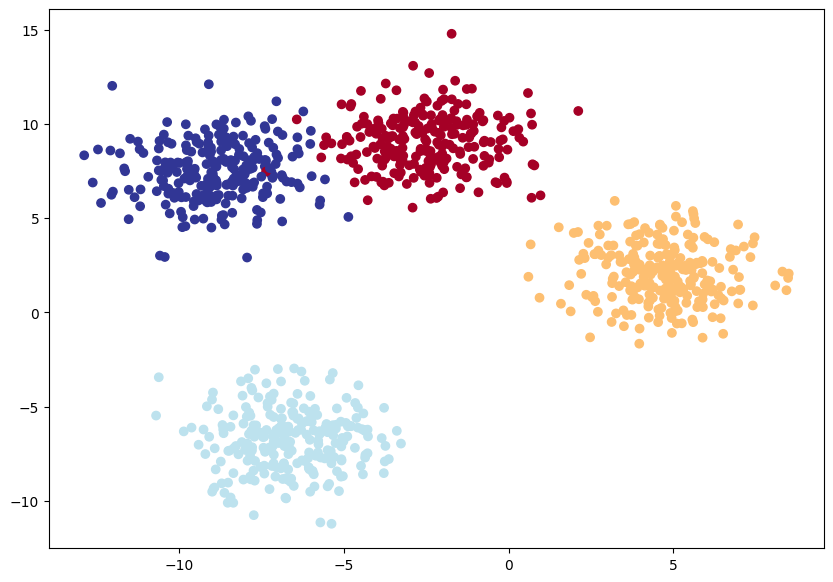

In [ ]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
           n_features=NUM_FEATURES,   # X features
           centers=NUM_CLASSES,   # y labels
           cluster_std=1.5,     # give the clusters a little shake up (try changing this to 1.0, the default)
           random_state=RANDOM_SEED
           )

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)   # creates a tensor from a NumPy array. Then specify the desired data type of the tensor.  "torch.float" corresponds to 32-bit floating-point numbers.
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0],   # selects all rows in the first from the X_blob array. It represents the x-coordinates of the scatter plot points.
            X_blob[:, 1],   # selects all rows in the second column from the X_blob array. It represents the y-coordinates of the scatter plot points.
            c=y_blob,   # assigns colors to the scatter plot points. Each unique value in "y_blob" will be associated with a different color.
            cmap=plt.cm.RdYlBu    # specifies the color map to use for mapping the values in "y_blob" to colors
            )

### 2 Building a multi-class classification model in PyTorch

let's create a subclass of `nn.Module` that takes in three hyperparameters:

* `input_features` - the number of X features coming into the model.
* `output_features` - the ideal numbers of output features we'd like (this will be equivalent to NUM_CLASSES or the number of classes in your multi-class classification problem).
* `hidden_units `- the number of hidden neurons we'd like each hidden layer to use.


Setup some device agnostic code.

Then we'll create the model class using the hyperparameters above.


In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torch import nn

# Build model
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):

    """Initializes all required hyperparameters for a multi-class classification model.

    Args:
        input_features (int): Number of input features to the model.
        out_features (int): Number of output features of the model
        (how many classes there are).
        hidden_units (int): Number of hidden units between layers, default 8.
    """

    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
        nn.Linear(in_features=hidden_units, out_features=output_features),   # how many classes are there?
    )

  def forward(self, x):
    return self.linear_layer_stack(x)


# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)

model_4


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Excellent! Our multi-class model is ready to go, let's create a loss function and optimizer for it.

### 3 Creating a loss function and optimizer for a multi-class PyTorch model
Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [ ]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1)   # exercise: try changing the learning rate here and seeing what happens to the model's performance

### 4 Getting prediction probabilities for a multi-class PyTorch model
Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.4681,  0.8642,  0.3397, -1.7642],
        [-1.6006,  2.4348,  2.9287, -1.8551],
        [ 0.6676, -2.1780, -1.4605,  2.0865],
        [ 0.2459, -1.0372, -0.4926,  0.9773],
        [-1.3160,  1.8612,  2.3808, -1.3674]], device='cuda:0',
       grad_fn=<SliceBackward0>)

What's coming out here?

It looks like we get one value per feature of each sample.

Let's check the shape to confirm.

In [ ]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)


Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from `logits -> prediction probabilities -> prediction labels` just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [ ]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimention 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2224,  1.1594,  0.7055, -1.9193],
        [-1.8926,  1.7896,  2.8292, -0.7156],
        [ 0.7767, -1.8890, -1.3976,  1.5971],
        [ 0.6361,  0.3366, -0.0852, -1.2251],
        [-1.3689,  2.5876,  2.8151, -2.2817]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.1890, 0.4824, 0.3064, 0.0222],
        [0.0064, 0.2541, 0.7187, 0.0208],
        [0.2895, 0.0201, 0.0329, 0.6575],
        [0.4197, 0.3110, 0.2040, 0.0653],
        [0.0084, 0.4382, 0.5501, 0.0034]], device='cuda:0',
       grad_fn=<SliceBackward0>)



Hmm, what's happened here?

It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

Let's check.

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)


These prediction probablities are essentially saying how much the model thinks the target `X` sample (the input) maps to each class.

Since there's one value for each class in `y_pred_probs`, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [ ]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.1890, 0.4824, 0.3064, 0.0222], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(1, device='cuda:0')



You can see the output of `torch.argmax()` returns 3, so for the features (`X`) of the sample at index 0, the model is predicting that the most likely class value (`y`) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

> **Note:** To summarize the above, a model's raw output is referred to as **logits**.

> For a multi-class classification problem, to turn the logits into **prediction probabilities**, you use the softmax activation function (`torch.softmax`).

> The index of the value with the highest **prediction probability** is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

### 5 Creating a training and testing loop for a multi-class PyTorch model
Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for `epochs=100` and evaluate it every 10 epochs

In [ ]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_true)) * 100
    return acc

In [ ]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 3.21672, Acc: 11.75% | Test Loss: 1.20768, Test Acc: 51.00%
Epoch: 10 | Loss: 0.14808, Acc: 99.38% | Test Loss: 0.13348, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08409, Acc: 99.38% | Test Loss: 0.07531, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06116, Acc: 99.25% | Test Loss: 0.05319, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04994, Acc: 99.25% | Test Loss: 0.04202, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04345, Acc: 99.25% | Test Loss: 0.03541, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03927, Acc: 99.25% | Test Loss: 0.03108, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03638, Acc: 99.12% | Test Loss: 0.02803, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03429, Acc: 99.12% | Test Loss: 0.02578, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03270, Acc: 99.12% | Test Loss: 0.02404, Test Acc: 99.50%


### 6 Making and evaluating predictions with a PyTorch multi-class model

It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [ ]:
# Make predictions
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  7.0249,  12.3726, -10.8751,  -6.7801],
        [  3.2673, -11.6089,   0.3129,   8.7265],
        [-10.5497, -15.4839,  15.9080,   6.9825],
        [  3.2569,   8.7798,  -5.8537,  -5.4880],
        [ 10.3390,   5.6264, -12.2900,  -1.0117],
        [  3.3941, -14.6189,   1.0925,  10.8653],
        [-10.3911, -12.1738,  14.7396,   4.7264],
        [  8.2288,   1.0276,  -8.6942,   1.5148],
        [-11.6385, -21.1490,  18.7609,  10.5809],
        [  8.8393,   2.6785,  -9.8316,   0.5606]], device='cuda:0')


Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (`y_blob_test`) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using `torch.softmax()`) then to prediction labels (by taking the `argmax()` of each sample).

> **Note**: It's possible to skip the `torch.softmax()` function and go straight from `predicted logits -> predicted labels` by calling `torch.argmax()` directly on the logits.

For example, `y_preds = torch.argmax(y_logits, dim=1)`, this saves a computation step (no `torch.softmax()`) but results in no prediction probabilities being available to use.

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')



Nice! Our model predictions are now in the same form as our test labels.

Let's visualize them with `plot_decision_boundary()`, remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (`plot_decision_boundary()` does this automatically for us).

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists, skipping download


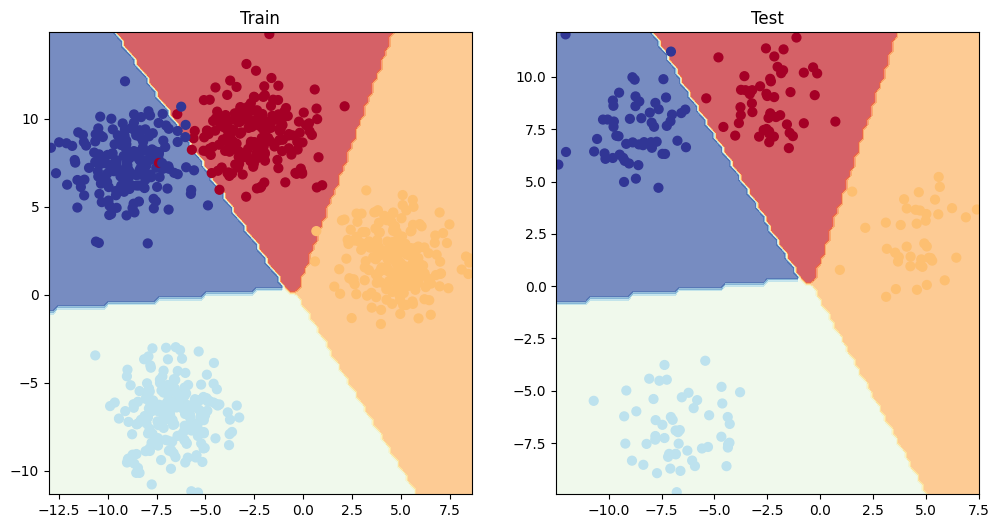

In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

# More classification evaluation metrics

So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:


| Metric name/Evaluation method | Defintion | code |
|--------| --------| --------|
| Accuracy | Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct. | torchmetrics.Accuracy() or sklearn.metrics.accuracy_score() |
| Precision | Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0). | torchmetrics.Precision() or sklearn.metrics.precision_score() |
| Recall | Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives. | torchmetrics.Recall() or sklearn.metrics.recall_score() |
| F1-score | Combines precision and recall into one metric. 1 is best, 0 is worst. | torchmetrics.F1Score() or sklearn.metrics.f1_s |
| **Confusion matrix** | Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line). | torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix() |
| Classification report | Collection of some of the main classification metrics such as precision, recall and f1-score. | sklearn.metrics.classification_report() |

Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out **TorchMetrics**, especially the **TorchMetrics classification section**.

Let's try the `torchmetrics.Accuracy` metric out.

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.9950, device='cuda:0')